# Enhancing AI Vision for Image Search

## Background

Working with Contentstack, we would like to have the ability to surface relevant image for an article being written by a Content Editor. The images may be related to a specific field like travel industry. In such a scenario, the content editors may have the article content ready. Cloudinary is expected to consume this free text and map it to an image that best matches the content.

For this purpose, we are going to do the following during an image upload:
* All incoming images are passed through AI Vision to obtain detailed description.
* The description is then converted to an embedding.
* The embedding information is then stored in a vector database.

When a content editor wishes to search for an image, the following happens:
* Content editors content is converted to an embedding.
* The information is passed on to a vector search for KNN match.
* The matched rows will point back to images on Cloudinary.
* Matched images are then displayed for the editor to choose.


This workbook demonstrates the end-to-end process of images being indexed and a search being executed.

In [1]:
import boto3
import json
import requests
import cloudinary
import cloudinary.api
from opensearchpy import OpenSearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import csv
from tqdm import tqdm

## Step 0: Setup

### Step 0.a: Load Environment variables & create AWS session

In [2]:
# load the environment variables
load_dotenv()

# create am AWS session
session = boto3.session.Session(profile_name='aws_sol')

### Step 0.b: Create an image object

We'll create an image object that will be used for all the steps.



In [3]:
class ImageObject:
    def __init__(self, public_id:str, url:str, description:str=''):
        self.public_id = public_id
        self.url = url
        self.description = description # initialize to empty string as this object will be created by making a Cloudinary API call.
        self.embedding = []
    
    def set_description(self, description:str)->None:
        self.description = description
    
    def set_embedding(self, embedding:list)->None:
        self.embedding = embedding  
        
    def __str__(self):
        return f"ImageObject(public_id={self.public_id}, url={self.url}, description={self.description})"


### Step 0.c: Setup Cloudinary credentials

In [4]:
cloudinary.config(
    cloud_name = os.environ.get('CLOUDINARY_CLOUD_NAME'),
    api_key = os.environ.get('CLOUDINARY_API_KEY'),
    api_secret = os.environ.get('CLOUDINARY_API_SECRET')
)

# setup an empty list for images
images = []

In [5]:
# Temporary code. Read the images already processed and don't re-run through AI vision
processed_images = set()
with open('image_descriptions.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        processed_images.add(row[0])

## Step 1: AI Vision on images

In [6]:
# make a Cloudinary Admin API "resource" call and get the image details
next_cursor = None
while True:

    resp = cloudinary.api.resources(
        type='upload',
        max_results=os.environ.get('NUM_IMAGES', 10), # maximum allowed is 500, defaults to 10
        prefix='pexelsassets/',
        next_cursor = next_cursor
    )

    # wrap this loop with tqdm
    for resource in tqdm(resp['resources'], desc="Fetching images"):
        if resource['public_id'] not in processed_images:
            images.append(ImageObject(public_id=resource['public_id'], url=resource['secure_url']))
    next_cursor = resp.get('next_cursor', None)
    if next_cursor == None:
        # no more images to process
        break
            

Fetching images: 100%|██████████| 399/399 [00:00<00:00, 1027965.17it/s]


In [7]:
def get_description(image_url:str)->str:
    url = os.environ.get('API_URL')    
    payload = {
        "source": {
            "uri": image_url
        },
        "prompts": [
            "Describe the image in detail. The target is a travel blog - so please focus on the background, the landscape and structures around the people"
        ]
    }

    resp = requests.post(
        url,
        json = payload
    )
    if resp.ok:    
        return resp.json()['data']['analysis']['responses'][0]['value']
    else:
        return None

In [8]:
# wrap this with tqdm
for img in tqdm(images):
    description = get_description(img.url)
    img.set_description(description)

  0%|          | 8/1899 [00:14<55:43,  1.77s/it]  

In [8]:
# parallel execution of the get description code
#import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# ... existing code ...

def get_description_batch(images, batch_size=3):
    file = open('image_descriptions.csv', 'a')
    writer = csv.writer(file)    
    csv_writer_lock = threading.Lock()

    with ThreadPoolExecutor(max_workers=batch_size) as executor:
        futures = [executor.submit(get_description, img.url) for img in images]
        for future, img in zip(as_completed(futures), images):
            description = future.result()
            img.set_description(description)
            with csv_writer_lock:
                writer.writerow([img.public_id, img.url, img.description])
    file.close()

# Replace the existing loop with this
batch_size = os.environ.get("BATCH_SIZE", 3)
total_images = len(images)
for i in tqdm(range(0, total_images, 3)):
    batch = images[i:i+batch_size]
    get_description_batch(batch, batch_size)

# ... rest of your code ...

100%|██████████| 9/9 [01:35<00:00, 10.62s/it]


In [34]:
## Logging
# Log the image id, URL and description so that we can use it to debug the response later.
with open('image_descriptions.csv', 'wa') as file:
    writer = csv.writer(file)
    #writer.writerow(['Image ID', 'URL', 'Description'])
    
    for img in images:
        writer.writerow([img.public_id, img.url, img.description])


## Step 2: Get Embeddings from the descriptions

After we have the descriptions, let's make another call back to Amazon and get back the text embeddings. For this, we'll be using `amazon.titan-embed-g1-text-02`.  

In [6]:
# create an instance of Bedrock Embedding
bedrock = session.client( os.environ.get('BEDROCK_CLIENT') )

def get_text_embedding(text:str, model:str=os.environ.get('BEDROCK_EMBED_MODEL')):
    embedding = []      
    if text:
        # Request to get embedding
        response = bedrock.invoke_model(
            modelId=model,
            body=json.dumps({"inputText": text}),
            contentType="application/json",
        )
        
        # Parse the response to get the embedding
        response_body = json.loads(response['body'].read())
        embedding = response_body['embedding']
        
    return embedding

In [7]:
if  images == [] or images == None:
        
    # this is when we are re-running a pre-existing image description data
    with open('image_descriptions.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            images.append(ImageObject(public_id=row[0], url=row[1], description=row[2]))

# wrap this with tqdm
for img in tqdm(images):
    embedding = get_text_embedding(img.description)
    img.set_embedding(embedding)

100%|██████████| 2399/2399 [09:00<00:00,  4.44it/s]


## Step 3: Store the embeddings 

To store the embeddings, we'll be creating an index in OpenSearch instance. We'll instantiate this to be a KNN type index and set the similarity metric to Eucleadean distance (L2). Once done, we'll save the embedding vectors. For simplicity, we'll save the image URL as the metadata so that it is easier to process the results later. In a real world, this would be the public-id of the asset.

### Step 3.a: Connect to an OpenSearch instance

We'll need to provide the AWS credentials and the name of the database for the connection.

In [8]:
# create the database index
host = os.environ.get('OPENSEARCH_HOST')
region = os.environ.get('AWS_REGION')
service = os.environ.get('SERVICE_NAME')
credentials = session.get_credentials()
awsauth = AWS4Auth(credentials.access_key, credentials.secret_key, region, service, session_token=credentials.token)

client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = awsauth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection
)

In [9]:
# delete the image index, if needed
client.indices.delete('images')

{'acknowledged': True}

### Step 3.b.: Create a KNN Index

If we don't explicity specify that the index is of type KNN, it will default to a regular index and won't allow similarity search.

In [10]:
# get the embedding length as the domension
index_name = os.environ.get('INDEX_NAME')
vector_dimension = os.environ.get('EMBEDDING_LENGTH')  # default for Amazon titan embedding is 1536

# Using the client, create an index
index_body = {
    "settings": {
        "index.knn": True,
        "index.knn.space_type": "l2"  # You can change this to "cosine" if you prefer cosine similarity
    },
    "mappings": {
        "properties": {
            "embedding": {  # This is your vector field name, change if needed
                "type": "knn_vector",
                "dimension": vector_dimension
            },
            "content": {"type": "text"},  # Assuming you store some text content
            "metadata": {"type": "object"},  # Assuming you store some metadata
            "url": {"type": "text"} # this will be the image URL
        }
    }
}

# Create the index
response = client.indices.create(index=index_name, body=index_body)
print(f"Index creation response: {response}")

Index creation response: {'acknowledged': True, 'shards_acknowledged': True, 'index': 'images'}


### Step 3.c: Load the embedding data into the index

Loop through the 3 arrays: `images`, `descriptions` and `embeddings`. Load the data into the index using these 3 values.

In [11]:
# now add the image info to the index
def index_embedding(image_id:str, embedding:str, metadata:str)->None:
    document = {
        'embedding': embedding,
        'description': metadata['description'],
        'tags': metadata['tags'],
        'url': metadata['url']
    }
    client.index(
        index="images",
        body=document,
        id=image_id,
        refresh=True
    )

In [12]:
# in the index, we need an imageId as the primary key. In reality, this could be the public id. For simplicity, I am using the index.

for img in tqdm(images):    
    metadata = {
        "tags": "testing",
        "description": img.description,
        "url": img.url
    }
    try:
        index_embedding(
        image_id=img.public_id,
            embedding=img.embedding,
            metadata=metadata
            
        )
    except Exception as e:
        print(e)
print("Image index loaded successfully.")

 18%|█▊        | 441/2399 [01:19<05:08,  6.34it/s]

RequestError(400, 'mapper_parsing_exception', "failed to parse field [embedding] of type [knn_vector] in document with id 'pexelsassets/evxyexuw8ognvyavfeyw'. Preview of field's value: 'null'")


 18%|█▊        | 443/2399 [01:20<04:46,  6.84it/s]

RequestError(400, 'mapper_parsing_exception', "failed to parse field [embedding] of type [knn_vector] in document with id 'pexelsassets/ewiewjcsnb6gev9xcx4b'. Preview of field's value: 'null'")


 19%|█▉        | 453/2399 [01:21<05:20,  6.08it/s]

RequestError(400, 'mapper_parsing_exception', "failed to parse field [embedding] of type [knn_vector] in document with id 'pexelsassets/ezpxolimi2ejeb60ocw3'. Preview of field's value: 'null'")


 19%|█▉        | 462/2399 [01:23<04:24,  7.32it/s]

RequestError(400, 'mapper_parsing_exception', "failed to parse field [embedding] of type [knn_vector] in document with id 'pexelsassets/fc2iqariqzmvu7qjxyv0'. Preview of field's value: 'null'")
RequestError(400, 'mapper_parsing_exception', "failed to parse field [embedding] of type [knn_vector] in document with id 'pexelsassets/fck3cncjtmeo7zq3ux07'. Preview of field's value: 'null'")


 19%|█▉        | 467/2399 [01:24<04:55,  6.54it/s]

RequestError(400, 'mapper_parsing_exception', "failed to parse field [embedding] of type [knn_vector] in document with id 'pexelsassets/fdb6qffvepvvve75ssky'. Preview of field's value: 'null'")


100%|██████████| 2399/2399 [07:15<00:00,  5.51it/s]

Image index loaded successfully.


## Step 4: Search for an image match

When searching for an image that matches the article, we'll need to do 2 things:
* Create an embedding of the article desciption
* Use the embedding for a similarity search on the database
* Extract the image URLs and display the images that are returned by the query.

### Step 4.a: Create embedding of the article

We'll re-use the embedding function `get_text_embedding` for getting the embedding of the text.

In [13]:
article = """
Lake Tahoe in winter is a snow-covered wonderland. The towering pines, dusted with a fresh layer of powder, create a serene and magical atmosphere. With crystal-clear waters and breathtaking mountain views, the lake offers a perfect escape for those seeking outdoor adventures like skiing, snowboarding, or snowshoeing.
"""

In [14]:
article_embedding = get_text_embedding(article)

### Step 4.b: Search for similar articles

Now, we'll execute a similarity search on the index we created in step 3.b

In [15]:
# now let us search for top 5 matches
def vector_search(client, index_name, query_vector, top_k=5):
    # Construct the search query
    search_query = {
        "size": top_k,
        "query": {
            "knn": {
                "embedding": {  # Make sure this matches your field name
                    "vector": query_vector,
                    "k": top_k
                }
            }
        }
    }
    
    # Perform the search
    response = client.search(
        body=search_query,
        index=index_name
    )
    
    return response['hits']['hits']

results = vector_search(client, 'images', article_embedding)
# Process and print results
for hit in results:
    print(f"Score: {hit['_score']}")
    print(f"Document ID: {hit['_id']}")
    #print(f"Content: {hit['_source'].get('description', 'N/A')}")  
    print(f"Metadata: {hit['_source'].get('url', '')}")  
    print("---")

Score: 0.007699599
Document ID: pexelsassets/wateskgv71rnie1wjylm
Metadata: https://naveen-hackathon-res.cloudinary.com/image/upload/v1725927693/pexelsassets/wateskgv71rnie1wjylm.jpg
---
Score: 0.0075509553
Document ID: pexelsassets/msigikkpgtuja3caux0l
Metadata: https://naveen-hackathon-res.cloudinary.com/image/upload/v1725976045/pexelsassets/msigikkpgtuja3caux0l.jpg
---
Score: 0.0073352894
Document ID: pexelsassets/mquoeomwvnpfugan04yb
Metadata: https://naveen-hackathon-res.cloudinary.com/image/upload/v1725937622/pexelsassets/mquoeomwvnpfugan04yb.jpg
---
Score: 0.0072433013
Document ID: pexelsassets/kacabvfpjka1sphs2er4
Metadata: https://naveen-hackathon-res.cloudinary.com/image/upload/v1725978147/pexelsassets/kacabvfpjka1sphs2er4.jpg
---
Score: 0.0071760053
Document ID: pexelsassets/a4rg8hxpnmb7ig2r4irf
Metadata: https://naveen-hackathon-res.cloudinary.com/image/upload/v1725976994/pexelsassets/a4rg8hxpnmb7ig2r4irf.jpg
---


### Step 4.c: Now display the matched images

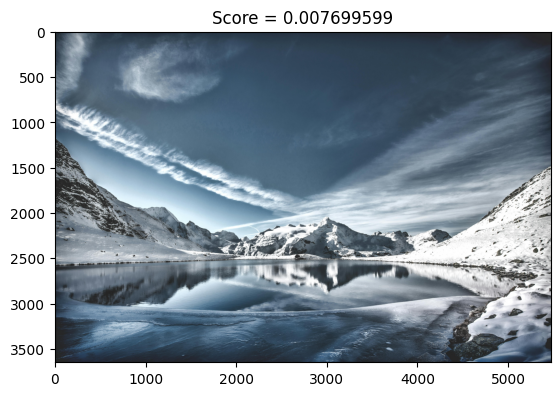

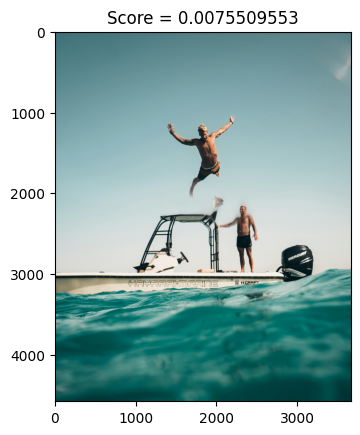

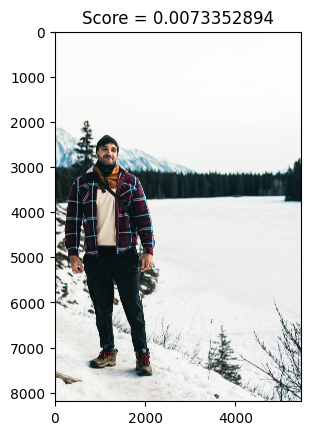

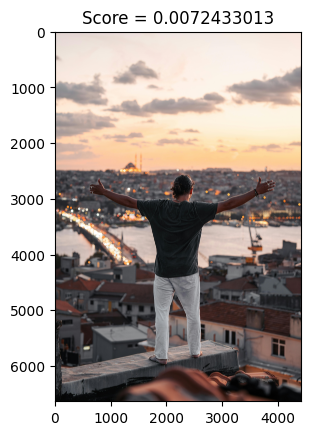

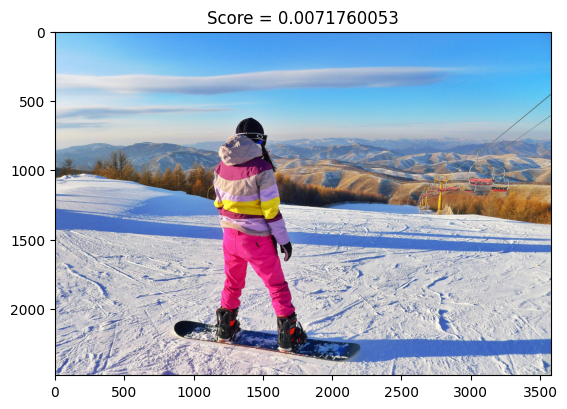

In [16]:
def display_url(url:str, score: float)->None:
    response = requests.get(url)
    
    if response.status_code == 200:
        image_data = BytesIO(response.content)
        img = Image.open(image_data)
        plt.imshow(img)
        plt.title(f'Score = {score}')
        plt.show()
    
def display_matched_images(results:str)->None:
    for hit in results:
        img_url = hit['_source'].get('url', '')
        if img_url:
            display_url(img_url, hit['_score'])

display_matched_images(results)

In [27]:
print(os.environ.get('NUM_IMAGES'))

500
